# Demonstrating use of real data for educational purposes.
In the midst of the ongoing AI revolution, that influences all parts of our society, there is a need to adjust our educational programs accordingly. There is a need to increase the general digital competence in the society, and for the students in technologically, natural sciences and mathematics/informatics this is especially important. 

In this file, we’ll demonstrate how to use Python and Jupyter to demonstrate real data during classes. 

For a general introduction to Jupyter, have a look at their https://jupyter-notebook.readthedocs.io/en/stable/notebook.html.

Python is a general purpose programming language with many user and community driven libraries. In here we will rely on a few of them. They will be installed as they are needed. Look at https://www.python.org/about/gettingstarted/ or one of the many online courses and introductory web pages. 

We will also demonstrate the use of AI in our coding practices. How that can save time to focus on the questions we are addressing, while being aware of the new challenges this technology poses. Both for students and for lecturers. Responsible use of AI will be important for the future, and as educational institutions, it is important that universities take their responsibility in this matter seriously.  

## The Meteostat data set. 

We will use available open data sources, that contains relatively fresh weather data from around the globe.  See https://meteostat.net/en for a general introduction, and https://dev.meteostat.net/python/ for the python library. 

We first install the library, if needed, then read it:

In [1]:
%pip install meteostat
# Import Meteostat library
from meteostat import Stations

Note: you may need to restart the kernel to use updated packages.


Let us select a location to look at. In the API for Meteostat they use Vancouver, Canada as example. We will later find other locations. Play with different locations. 

In [7]:
latlon=(49.2497, -123.1193)  # Example coordinates for Vancouver, Canada, used in their documentation.
number_of_stations = 2  # Number of stations to fetch
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(49.2497, -123.1193)
station = stations.fetch(number_of_stations)


# Print DataFrame
print(station)

                       name country region    wmo  icao  latitude  longitude  \
id                                                                             
71201  Vancouver Harbour CS      CA     BC  71201  CWHC     49.30    -123.12   
R1RBA   N Vancouver Wharves      CA     BC   <NA>  <NA>     49.31    -123.12   

       elevation           timezone hourly_start hourly_end daily_start  \
id                                                                        
71201        2.0  America/Vancouver   1980-03-01 2025-04-24  1925-11-01   
R1RBA        7.0  America/Vancouver          NaT        NaT  2000-01-01   

       daily_end monthly_start monthly_end     distance  
id                                                       
71201 2024-04-28    1925-01-01  2022-01-01  5593.335349  
R1RBA 2022-12-12    2000-01-01  2018-01-01  6705.246345  


We notice that we do get other locations and also the distance from the location given. 

### Find another location
We can either google the position we are in or we can use geopy, another library, to find the latitude and longitude. 


In [8]:
import geopy
from geopy.geocoders import Nominatim

location_txt = "Makerere University, Kampala, Uganda"
# Use geopy to find the latitude and longitude.
geolocator = Nominatim(user_agent="makerere_locator")
location = geolocator.geocode(location_txt, exactly_one=True, timeout=10)
if location:
    location_latlon = (location.latitude, location.longitude)
    print(f"{location_txt}: {location_latlon}")
else:
    location=(0.316700,32.616700)
    print("Location not found, har coding coordinates to Makerere University, Kampala, Uganda")

Makerere University, Kampala, Uganda: (0.335151, 32.5682342)


# Find nearby weather stations. 
We now have the location stored, lets find nearby weather stations. 
We'll use IPython.display to make nicer output. 

In [9]:
from IPython.display import display

number_of_stations = 10  # Number of stations to fetch
stations = stations.nearby(location_latlon[0], location_latlon[1])
station = stations.fetch(number_of_stations) 

# Print DataFrame

# Display the DataFrame with better formatting
display(station.style.set_caption(f"Nearby Weather Stations for {location_txt}").background_gradient(cmap='Blues'))

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
63680,Kampala,UG,KM,63680,,0.316700,32.616700,1144.000000,Africa/Kampala,1973-01-02 00:00:00,2025-04-12 00:00:00,NaT,NaT,NaT,NaT,5766.394728
63705,Entebbe Airport,UG,WA,63705,HUEN,0.050000,32.450000,1155.000000,Africa/Kampala,1949-01-21 00:00:00,2025-06-28 00:00:00,1957-01-02 00:00:00,2022-04-25 00:00:00,1949-01-01 00:00:00,2002-01-01 00:00:00,34324.890858
63682,Jinja,UG,JI,63682,HUJI,0.450000,33.183300,1175.000000,Africa/Kampala,1957-01-01 00:00:00,2025-06-27 00:00:00,1955-01-01 00:00:00,1986-12-30 00:00:00,1955-01-01 00:00:00,1986-01-01 00:00:00,69572.697804
63654,Masindi,UG,MZ,63654,HUMI,1.683300,31.716700,1146.000000,Africa/Kampala,1963-03-16 00:00:00,2025-06-27 00:00:00,1926-01-01 00:00:00,1984-12-31 00:00:00,1926-01-01 00:00:00,1984-01-01 00:00:00,177297.783889
63684,Tororo,UG,TR,63684,HUTO,0.683300,34.166700,1170.000000,Africa/Kampala,1957-01-01 00:00:00,2025-05-14 00:00:00,1929-01-01 00:00:00,1986-12-31 00:00:00,1929-01-01 00:00:00,1986-01-01 00:00:00,181901.134038
63658,Soroti,UG,ST,63658,HUSO,1.716700,33.616700,1132.000000,Africa/Kampala,1973-01-01 00:00:00,2025-06-27 00:00:00,NaT,NaT,NaT,NaT,192837.537997
63729,Bukoba,TZ,KA,63729,HTBU,-1.333300,31.816700,1137.000000,Africa/Dar_es_Salaam,1957-01-01 00:00:00,2025-06-27 00:00:00,1950-01-01 00:00:00,2021-12-26 00:00:00,1950-01-01 00:00:00,1989-01-01 00:00:00,203473.032315
HULI0,Lira,UG,LL,,HULI,2.250000,32.900000,1091.000000,Africa/Kampala,1985-04-08 00:00:00,2025-06-27 00:00:00,NaT,NaT,NaT,NaT,216091.797958
63702,Mbarara,UG,RR,63702,HUMA,-0.616700,30.650000,1412.000000,Africa/Kampala,1957-01-01 00:00:00,2025-06-27 00:00:00,1926-01-01 00:00:00,1976-12-31 00:00:00,1926-01-01 00:00:00,1976-01-01 00:00:00,238111.309172


Let's plot the location in a map. 

In [10]:
%pip install folium
import folium

# Create a map centered at Dar es Salaam
m = folium.Map(location=location_latlon, zoom_start=7)

# Add markers for each station
for idx, row in station.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['name']} (WMO: {row['wmo']})",
        tooltip=row['name']
    ).add_to(m)
# Add a circle marker for the specified location
folium.CircleMarker(
        location=[location_latlon[0], location_latlon[1]],
        popup=f"Our location: {location_txt}",
        tooltip=location_txt,
        color='red'
    ).add_to(m)
folium.Marker(
        location=[location_latlon[0], location_latlon[1]],
        popup=f"Our location: {location_txt}",
        tooltip=location_txt,
        icon=folium.Icon(icon='cloud', color='red', icon_color='white', prefix='fa')
    ).add_to(m)
# Display the map
m

Note: you may need to restart the kernel to use updated packages.


# Read data
Now we can read and manipulate data. Let's first see how correlated the different stations are. We need some more libraries. 


In [11]:
import pandas as pd
from meteostat import Daily
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
from meteostat import Hourly
from datetime import datetime

# Define a time period for the data (e.g., last 30 days)
# Find the earliest common end time and latest common start time across all stations
hourly_starts = station['hourly_start'].dropna()
hourly_ends = station['hourly_end'].dropna()
start = hourly_starts.max().to_pydatetime()
end = hourly_ends.min().to_pydatetime()


# Prepare DataFrames to collect hourly temperature, wind speed, and precipitation
temp_hourly_df = pd.DataFrame()
wspd_hourly_df = pd.DataFrame()
prcp_hourly_df = pd.DataFrame()

for wmo in station.index:
    try:
        # Skip stations without a valid WMO code
        if not str(wmo).isdigit():
            continue
        hourly = Hourly(wmo, start, end).fetch()
        if not hourly.empty:
            if 'temp' in hourly.columns:
                temp_hourly_df[wmo] = hourly['temp']
            if 'wspd' in hourly.columns:
                wspd_hourly_df[wmo] = hourly['wspd']
            if 'prcp' in hourly.columns:
                prcp_hourly_df[wmo] = hourly['prcp']
    except Exception as e:
        print(f"Error fetching hourly data for station {wmo}: {e}")

# Align all DataFrames to the same time index
if not temp_hourly_df.empty:
    wspd_hourly_df = wspd_hourly_df.reindex(temp_hourly_df.index)
    prcp_hourly_df = prcp_hourly_df.reindex(temp_hourly_df.index)

# Show a summary of the data
print("Hourly temperature data:")
print(temp_hourly_df.head())
print("\nHourly wind speed data:")
print(wspd_hourly_df.head())
print("\nHourly precipitation data:")
print(prcp_hourly_df.head())

Hourly temperature data:
                     63680  63705  63682  63654  63684  63658  63729  63702  \
time                                                                          
1993-02-11 12:00:00   24.4   23.0    NaN   29.2    NaN   24.5   22.8   25.5   
1993-02-12 12:00:00   30.0   25.0   28.5   29.8    NaN   30.0    NaN   25.6   
1993-02-16 12:00:00   29.3   25.2    NaN   29.4    NaN   31.6   25.0    NaN   
1993-02-17 12:00:00   29.5   24.8    NaN   28.6    NaN   32.0    NaN   26.6   
1993-02-25 12:00:00   22.4   17.2    NaN    NaN    NaN    NaN    NaN    NaN   

                     63733  
time                        
1993-02-11 12:00:00   20.2  
1993-02-12 12:00:00   27.4  
1993-02-16 12:00:00   27.0  
1993-02-17 12:00:00    NaN  
1993-02-25 12:00:00    NaN  

Hourly wind speed data:
                     63680  63705  63682  63654  63684  63658  63729  63702  \
time                                                                          
1993-02-11 12:00:00    0.0   16.6  

In [ ]:
from meteostat import Hourly

# Set the time period for hourly data (using 'start' and the last timestamp in temp_hourly_df)

# Prepare to collect hourly temperature, wind speed, and precipitation for each station
temp_hourly_df = pd.DataFrame()
wspd_hourly_df = pd.DataFrame()
prcp_hourly_df = pd.DataFrame()

for wmo in station.index:
    try:
        # Some stations may not have a valid WMO code (e.g., 'HULI0'), skip those
        if not str(wmo).isdigit():
            continue
        hourly = Hourly(wmo, start, end).fetch()
        if not hourly.empty:
            if 'temp' in hourly.columns:
                temp_hourly_df[wmo] = hourly['temp']
            if 'wspd' in hourly.columns:
                wspd_hourly_df[wmo] = hourly['wspd']
            if 'prcp' in hourly.columns:
                prcp_hourly_df[wmo] = hourly['prcp']
    except Exception as e:
        print(f"Error fetching hourly data for station {wmo}: {e}")

# Align all DataFrames to the same time index
if not temp_hourly_df.empty:
    wspd_hourly_df = wspd_hourly_df.reindex(temp_hourly_df.index)
    prcp_hourly_df = prcp_hourly_df.reindex(temp_hourly_df.index)

# Show a summary of the data
print("Hourly temperature data:")
print(temp_hourly_df.head())
print("\nHourly wind speed data:")
print(wspd_hourly_df.head())
print("\nHourly precipitation data:")
print(prcp_hourly_df.head())

Hourly temperature data:
                     63680  63705  63682  63654  63684  63658  63729  63702  \
time                                                                          
1993-02-11 12:00:00   24.4   23.0    NaN   29.2    NaN   24.5   22.8   25.5   
1993-02-12 12:00:00   30.0   25.0   28.5   29.8    NaN   30.0    NaN   25.6   
1993-02-16 12:00:00   29.3   25.2    NaN   29.4    NaN   31.6   25.0    NaN   
1993-02-17 12:00:00   29.5   24.8    NaN   28.6    NaN   32.0    NaN   26.6   
1993-02-25 12:00:00   22.4   17.2    NaN    NaN    NaN    NaN    NaN    NaN   

                     63733  
time                        
1993-02-11 12:00:00   20.2  
1993-02-12 12:00:00   27.4  
1993-02-16 12:00:00   27.0  
1993-02-17 12:00:00    NaN  
1993-02-25 12:00:00    NaN  

Hourly wind speed data:
                     63680  63705  63682  63654  63684  63658  63729  63702  \
time                                                                          
1993-02-11 12:00:00    0.0   16.6  

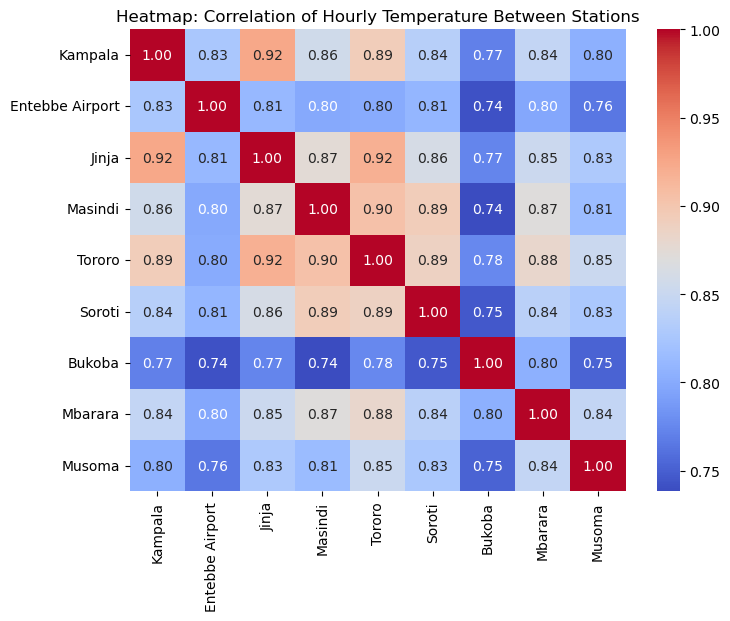

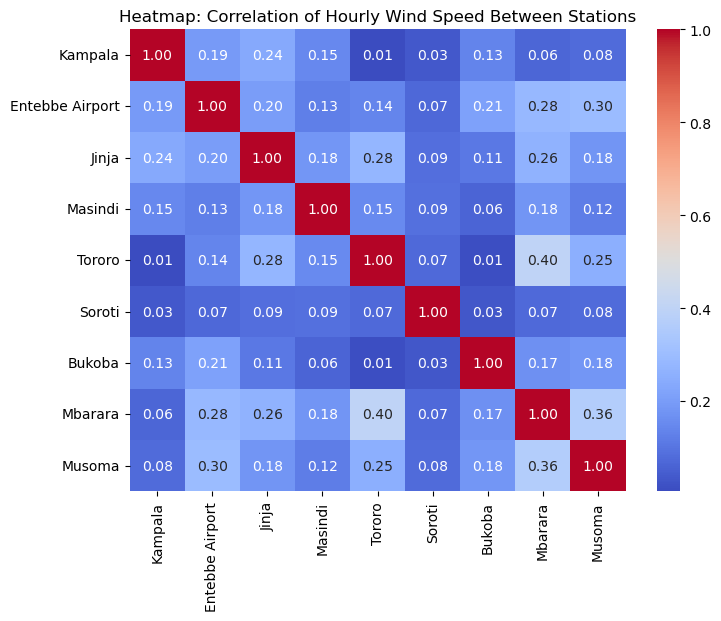

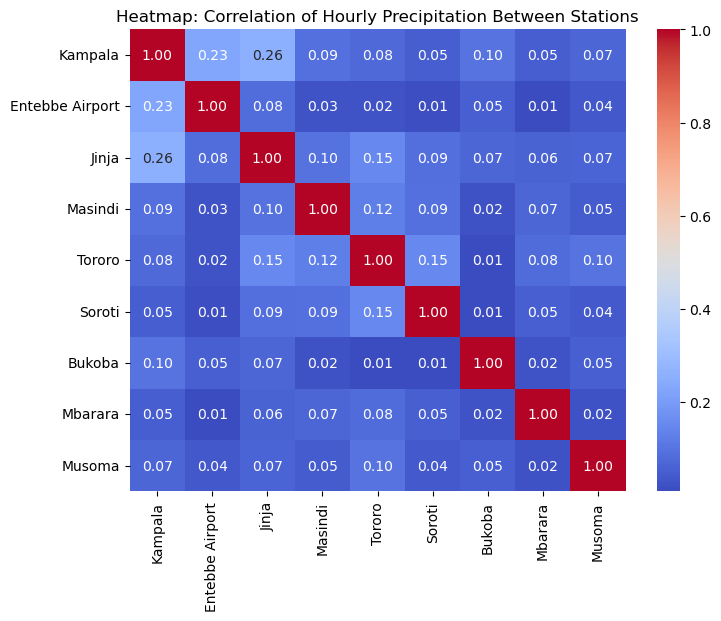

In [16]:
import seaborn as sns

# Compute correlation matrices for temperature, wind speed, and precipitation
temp_corr = temp_hourly_df.corr()
wspd_corr = wspd_hourly_df.corr()
prcp_corr = prcp_hourly_df.corr()

# Map WMO codes to station names for better readability
wmo_to_name = station['name'].to_dict()

import matplotlib.pyplot as plt

# Plot heatmaps with station names as axes
for label, corr in {'Temperature': temp_corr, 'Wind Speed': wspd_corr, 'Precipitation': prcp_corr}.items():
    if not corr.empty:
        corr_named = corr.rename(index=wmo_to_name, columns=wmo_to_name)
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_named, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Heatmap: Correlation of Hourly {label} Between Stations")
        plt.show()
    else:
        print(f"No data available for {label}")

In [ ]:

# Compute the correlation between the weather stations
# We'll use latitude, longitude, elevation, and distance for correlation
# Set the time period for all stations (use the same as data_day)
start = data_day.index.min()
end = data_day.index.max()

# Prepare to collect daily mean temperature and wind speed for each station
station_temp = {}
station_wspd = {}

for idx, row in dar_station.iterrows():
    wmo = row['wmo']
    try:
        daily = Daily(wmo, start, end).fetch()
        if not daily.empty:
            # Only add if both tavg and wspd are present
            if 'tavg' in daily.columns and 'wspd' in daily.columns:
                station_temp[wmo] = daily['tavg']
                station_wspd[wmo] = daily['wspd']
    except Exception as e:
        print(f"Error fetching data for station {wmo}: {e}")

# Combine into DataFrames aligned by date
temp_df = pd.DataFrame(station_temp)
wspd_df = pd.DataFrame(station_wspd)

# Compute correlation matrices
temp_corr = temp_df.corr()
wspd_corr = wspd_df.corr()

print("Correlation matrix for daily mean temperature (tavg) between stations:")
print(temp_corr)
print("\nCorrelation matrix for daily mean wind speed (wspd) between stations:")
print(wspd_corr)


    # Plot heatmap for temperature correlation
plt.figure(figsize=(8, 6))
sns.heatmap(temp_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap: Correlation of Daily Mean Temperature (tavg) Between Stations")
plt.show()

    # Map WMO codes to station names for better readability in the heatmap
wmo_to_name = dar_station['name'].to_dict()
    # Reindex correlation matrices with station names
wspd_corr_named = wspd_corr.rename(index=wmo_to_name, columns=wmo_to_name)

    # Plot heatmap for wind speed correlation using station names
plt.figure(figsize=(8, 6))
sns.heatmap(wspd_corr_named, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Heatmap: Correlation of Daily Mean Wind Speed (wspd) Between Stations (by Name)")
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(wspd_corr, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Heatmap: Correlation of Daily Mean Wind Speed (wspd) Between Stations")
plt.show()

In [30]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Daily
# Set time period
start = datetime(2025, 5, 1)
end = datetime(2025, 6, 27, 23, 59)

# Get hourly data
data = Hourly('63894', start, end)#, model=False)
data = data.fetch()
data_day= Daily('63894', start, end)
data_day = data_day.fetch() 
# Print DataFrame
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2025-05-01 00:00:00,24.3,23.3,94.0,0.0,NaN,220.0,9.3,NaN,1011.2,NaN,7.0
2025-05-01 01:00:00,24.0,22.1,89.0,0.0,NaN,240.0,9.0,NaN,1011.0,NaN,7.0
2025-05-01 02:00:00,24.0,19.9,78.0,0.0,NaN,200.0,7.0,NaN,1011.0,NaN,7.0
2025-05-01 03:00:00,24.0,22.1,89.0,0.0,NaN,220.0,7.0,NaN,1011.0,NaN,8.0
2025-05-01 04:00:00,24.0,23.0,94.0,0.0,NaN,210.0,9.0,NaN,1012.0,NaN,7.0


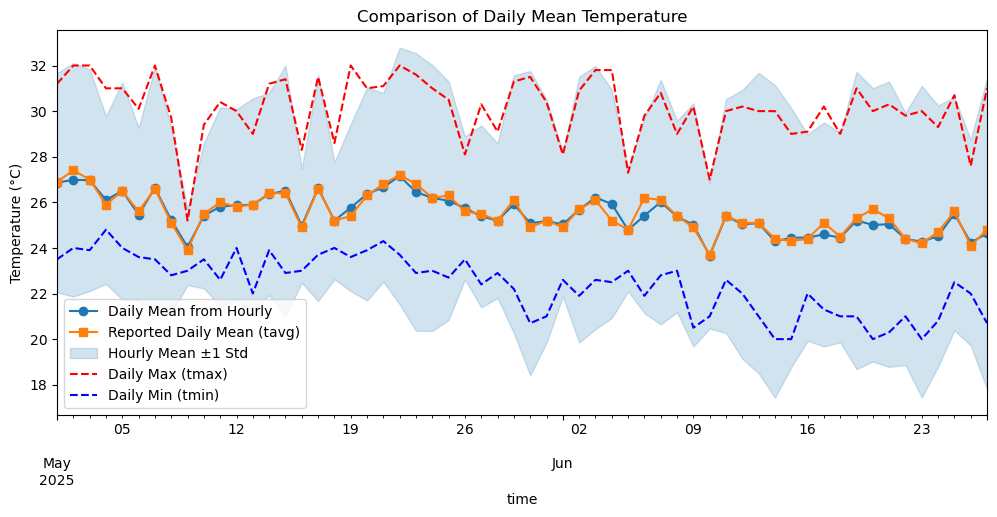

In [38]:
# Calculate daily mean temperature from hourly data
from matplotlib import pyplot as plt


hourly_daily_mean = data['temp'].resample('D').mean()

# Plot both the daily mean from hourly and the reported daily mean (tavg)
plt.figure(figsize=(12, 5))
hourly_daily_mean.plot(label='Daily Mean from Hourly', style='-o')
data_day['tavg'].plot(label='Reported Daily Mean (tavg)', style='-s')
plt.title('Comparison of Daily Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
# Add a shadow (fill) for the daily mean from hourly ±1 std
hourly_daily_std = data['temp'].resample('D').std()
plt.fill_between(hourly_daily_mean.index, 
                 hourly_daily_mean - 2*hourly_daily_std, 
                 hourly_daily_mean + 2*hourly_daily_std, 
                 color='C0', alpha=0.2, label='Hourly Mean ±1 Std')

data_day['tmax'].plot(label='Daily Max (tmax)', style='--', color='red')
data_day['tmin'].plot(label='Daily Min (tmin)', style='--', color='blue')
plt.legend()
plt.show()

In [6]:
data.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2025-07-10 05:00:00,23.5,20.4,83.0,NaN,NaN,209.0,14.8,NaN,1019.5,NaN,2.0
2025-07-10 06:00:00,24.4,20.7,80.0,NaN,NaN,206.0,14.8,NaN,1019.7,NaN,2.0
2025-07-10 07:00:00,25.8,20.4,72.0,NaN,NaN,194.0,18.5,NaN,1019.5,NaN,2.0
2025-07-10 08:00:00,27.1,20.0,65.0,NaN,NaN,183.0,20.4,NaN,1019.2,NaN,3.0
2025-07-10 09:00:00,28.4,19.6,59.0,NaN,NaN,174.0,22.2,NaN,1019.0,NaN,3.0


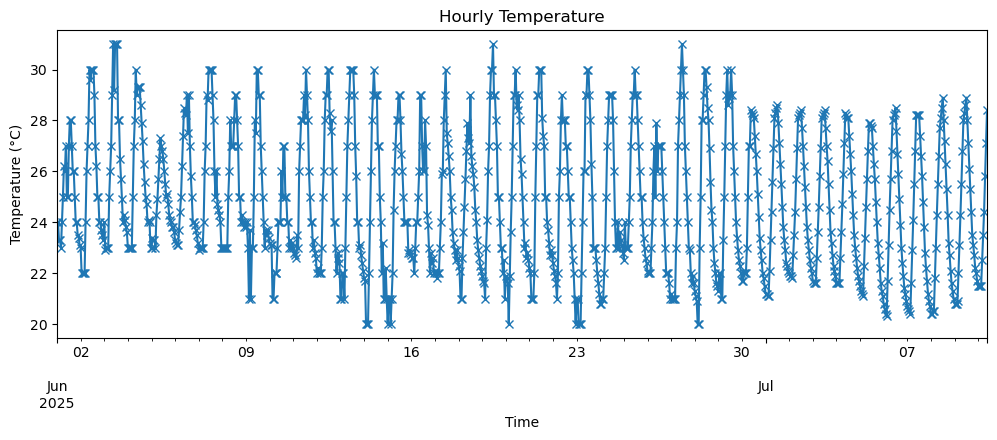

In [7]:
import matplotlib.pyplot as plt

data['temp'].plot(figsize=(12, 4), title='Hourly Temperature', style='-' \
'x')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

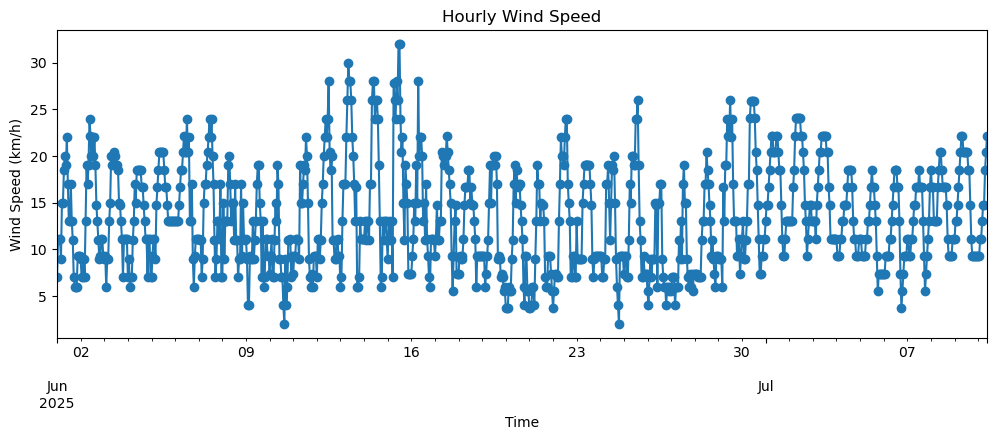

time
2025-06-01 00:00:00     7.0
2025-06-01 01:00:00    11.0
2025-06-01 02:00:00    11.1
2025-06-01 03:00:00    11.1
2025-06-01 04:00:00     9.0
                       ... 
2025-07-10 05:00:00    14.8
2025-07-10 06:00:00    14.8
2025-07-10 07:00:00    18.5
2025-07-10 08:00:00    20.4
2025-07-10 09:00:00    22.2
Name: wspd, Length: 946, dtype: float64

In [8]:
data['wspd'].plot(figsize=(12, 4), title='Hourly Wind Speed',style="-o")
plt.xlabel('Time')
plt.ylabel('Wind Speed (km/h)')
plt.show()
data['wspd']

# Uganda


In [52]:
mak_pos=(0.355,32.583)
mak_stations = stations.nearby(*mak_pos)
mak_station = mak_stations.fetch(10)
mak_station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
63680,Kampala,UG,KM,63680,<NA>,0.3167,32.6167,1144.0,Africa/Kampala,1973-01-02,2025-04-12,NaT,NaT,NaT,NaT,5672.620856
63705,Entebbe Airport,UG,WA,63705,HUEN,0.0500,32.4500,1155.0,Africa/Kampala,1949-01-21,2025-06-28,1957-01-02,2022-04-25,1949-01-01,2002-01-01,36998.637250
63682,Jinja,UG,JI,63682,HUJI,0.4500,33.1833,1175.0,Africa/Kampala,1957-01-01,2025-06-27,1955-01-01,1986-12-30,1955-01-01,1986-01-01,67579.371788
63654,Masindi,UG,MZ,63654,HUMI,1.6833,31.7167,1146.0,Africa/Kampala,1963-03-16,2025-06-27,1926-01-01,1984-12-31,1926-01-01,1984-01-01,176326.739828
63684,Tororo,UG,TR,63684,HUTO,0.6833,34.1667,1170.0,Africa/Kampala,1957-01-01,2025-05-14,1929-01-01,1986-12-31,1929-01-01,1986-01-01,179836.053494
63658,Soroti,UG,ST,63658,HUSO,1.7167,33.6167,1132.0,Africa/Kampala,1973-01-01,2025-06-27,NaT,NaT,NaT,NaT,190086.841798
63729,Bukoba,TZ,KA,63729,HTBU,-1.3333,31.8167,1137.0,Africa/Dar_es_Salaam,1957-01-01,2025-06-27,1950-01-01,2021-12-26,1950-01-01,1989-01-01,206160.530426
HULI0,Lira,UG,LL,<NA>,HULI,2.2500,32.9000,1091.0,Africa/Kampala,1985-04-08,2025-06-27,NaT,NaT,NaT,NaT,213640.526160
63702,Mbarara,UG,RR,63702,HUMA,-0.6167,30.6500,1412.0,Africa/Kampala,1957-01-01,2025-06-27,1926-01-01,1976-12-31,1926-01-01,1976-01-01,240566.332835


In [53]:
import folium

# Center the map at the mean latitude and longitude of the stations
center_lat = mak_station['latitude'].mean()
center_lon = mak_station['longitude'].mean()
map_mak = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add markers for each station in mak_station
for idx, row in mak_station.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['name']} (WMO: {row['wmo']})",
        tooltip=row['name']
    ).add_to(map_mak)

# Display the map in Jupyter Notebook
map_mak

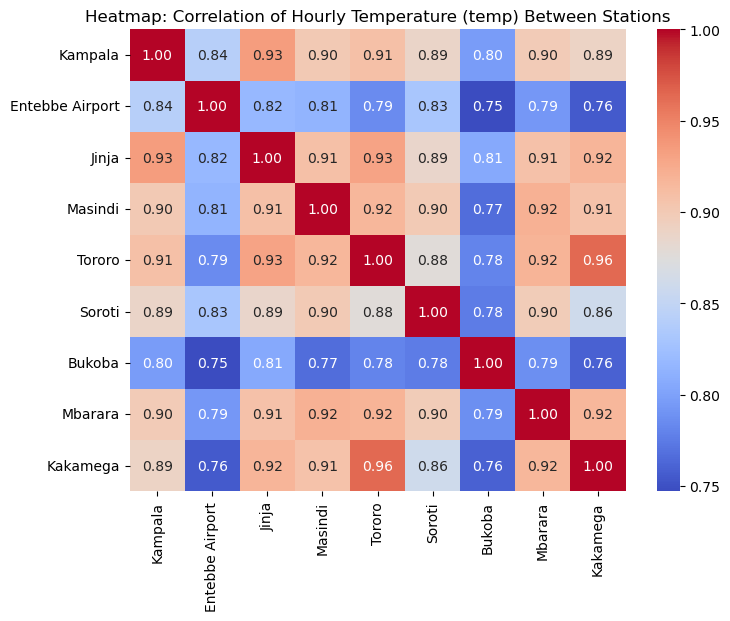

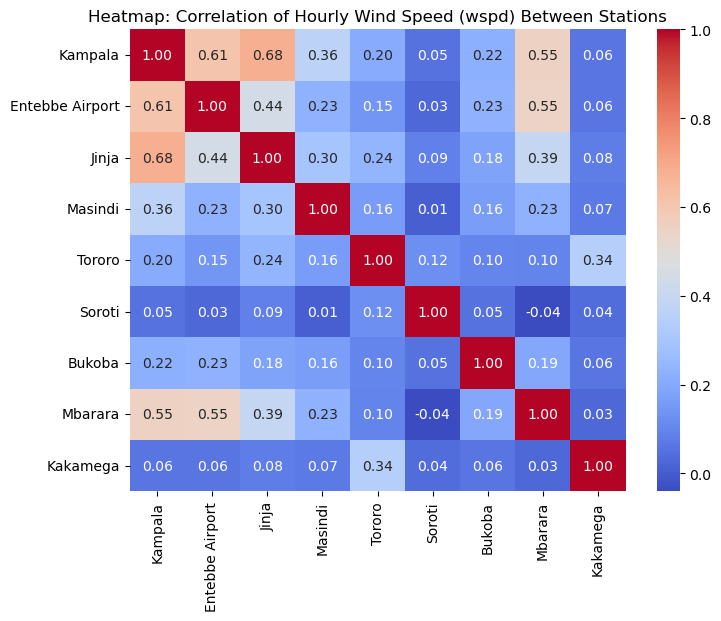

No data available for Gust (gust)


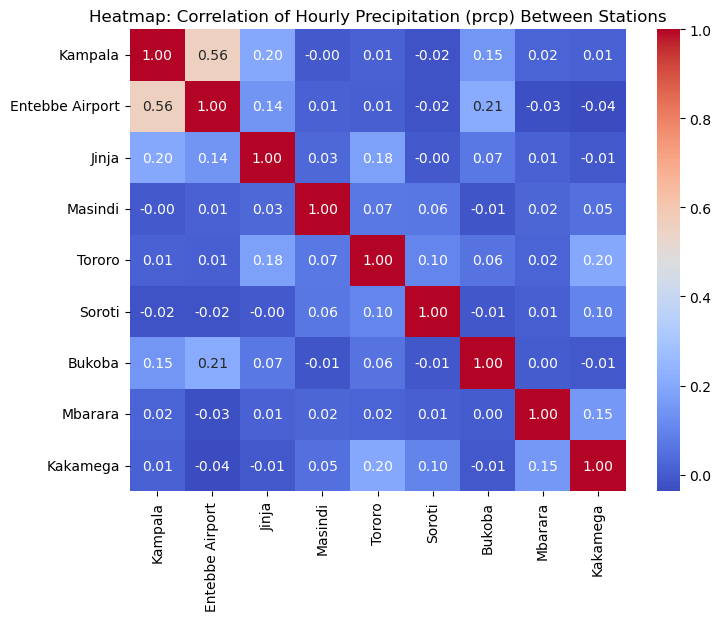

In [55]:
# Map WMO codes to station names for better readability
wmo_to_name = mak_station['name'].to_dict()

# Plot heatmaps with station names as axes
for label, corr in corrs.items():
    if not corr.empty:
        corr_named = corr.rename(index=wmo_to_name, columns=wmo_to_name)
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_named, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Heatmap: Correlation of Hourly {label} Between Stations")
        plt.show()
    else:
        print(f"No data available for {label}")


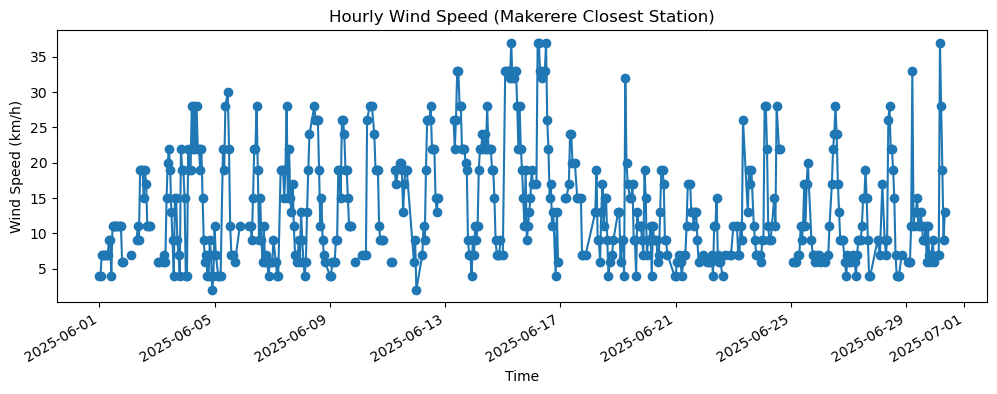

In [13]:
from meteostat import Hourly
from datetime import datetime

# Get the WMO ID of the closest station to Makerere University
mak_closest_wmo = mak_station.index[1]

# Set a time period (use the same as before for consistency)

mak_start = datetime(2025, 6, 1)
mak_end = datetime(2025, 7, 27, 23, 59)


    
mak_data = Hourly(mak_closest_wmo, mak_start, mak_end, model=False).fetch()


# Plot wind speed if data is available
if not mak_data.empty and 'wspd' in mak_data.columns:
    mak_data['wspd'].plot(figsize=(12, 4), title='Hourly Wind Speed (Makerere Closest Station)',style='-o')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed (km/h)')
    plt.show()
else:
    print("No wind speed data available for the selected station and period.")


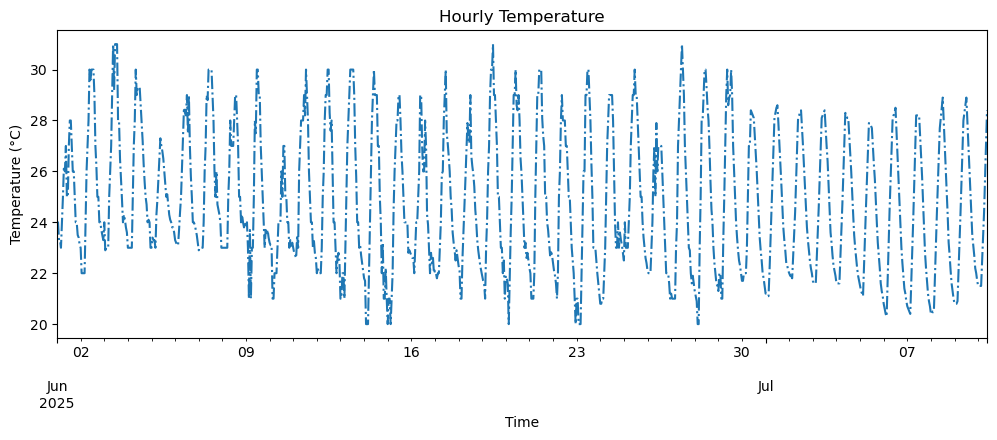

In [15]:
data['temp'].plot(figsize=(12, 4), title='Hourly Temperature', style='-.')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()